In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


from HSI_class import HSI
import zeroPadding
import augmentation as aug
import createSample as CS

start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True
seed = 55

sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size = 20
test_size = 0.5

random_indices = 0

GPU Available: True
GPU Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # PyTorch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

if seeded_run:
    set_seed(seed)
    print("seed has been set")
    print(f"seet used: {seed}")

seed has been set
seet used: 55


In [3]:
dataset_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM08.mat


In [4]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [5]:
def predict_batch(model, batch_input, device):
  test_features_np = torch.flatten(batch_input, start_dim=1)  # Flatten all dims except batch


  # --- Predict class labels and probabilities ---
  predicted_classes = model.predict(test_features_np)
  probs = model.predict_proba(test_features_np)
  positive_probs = probs[:, 1]  # probability of class 1

  return predicted_classes, positive_probs


In [6]:
hsi_ = datasets[0]
patch_size = 9


indices_0 = []
indices_1 = []

print(f"random: {random_indices}")
random_indices = 1
if random_indices:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
generating random sample
hsi shape
(1243, 684, 224)
creating 5 Randomly chosen 0 indices:
creating 5 Randomly chosen 1 indices:
indices 0 used: [(np.int64(144), np.int64(561)), (np.int64(319), np.int64(409)), (np.int64(244), np.int64(479)), (np.int64(1175), np.int64(174)), (np.int64(488), np.int64(196))]
indices 1 used: [(np.int64(1102), np.int64(103)), (np.int64(113), np.int64(43)), (np.int64(963), np.int64(39)), (np.int64(160), np.int64(195)), (np.int64(232), np.int64(222))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [7]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-245 -455  358  410  441  591  649  646  622  601  559  504  461  430
  400  382  349  326  304  281  246  227  200  177  148  141  127  119
  112  108   97   88   91   85   78   72   58   51   40   14   31   45
   51   23   37   46   40   38   37   24   22   26   43   40   38   34
   38   20    8    1    8   -3 -143  -49    9   19   31   40   40   46
   47   39   45   44   47   42   32   27   15  -16 -191 -193  -93  -85
  -20    9   25   18   27   18   38   31   43   39   34   47   36   26
   22   11   17   10    0  152  -18  -54    0    0    0    0    0    0
    0    0 -342 -304  -89  -50 -109  -46   -3   -2    5   10   10   17
   16   10    8   19   16    9   18   16   14   15   12   13   14   16
   19   20   19   10   17   -1    6    5    1   -9    3   47    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  -23  -42  -11    3   -8  -18  -47   -2    8   10    9   12    9   11
   14   14   10   18   14   21   17   20   18   18   11   17   16   15
   16 

In [8]:
n_category = 2
band_size = 224

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

# # Count occurrences of each unique element
# counts1 = np.bincount(label_augment1)

# # Print results
# for i, count in enumerate(counts1):
#     print(f"Element {i} occurs {count} times.")

# counts2 = np.bincount(label_augment2)

# # Print results
# for i, count in enumerate(counts2):
#     print(f"Element {i} occurs {count} times.")

# print(label_augment1[3])

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [9]:
# class ConvTo1D(nn.Module):
#     def __init__(self):
#         super(ConvTo1D, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch_size, 128, 1, 1)
#         self.flatten = nn.Flatten()               # (batch_size, 128)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.flatten(x)
#         return x

# feature_extractor = ConvTo1D()

In [10]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

features_np = torch.flatten(x_data, start_dim=1)  # Flatten all dims except batch

    

print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
torch.Size([40, 18144])


In [11]:
X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

print(y_train)
print(y_val)

[1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1]
[0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0]


In [12]:
# --- Train Random Forest Classifier ---
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_leaf=2,
        min_samples_split=2,
        random_state=seed
    )
)
pipeline.fit(X_train, y_train)

# --- Predict class labels and probabilities ---
predicted_classes = pipeline.predict(X_val)
probs = pipeline.predict_proba(X_val)
positive_probs = probs[:, 1]  # probability of class 1

# --- Display predictions with probabilities ---
for i, (pred, prob) in enumerate(zip(predicted_classes, positive_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")

# --- Accuracy ---
acc = accuracy_score(y_val, predicted_classes)
print(f"Validation Accuracy: {acc:.4f}")

Sample 0: Predicted = 0, Prob(class 1) = 0.0450
Sample 1: Predicted = 0, Prob(class 1) = 0.0700
Sample 2: Predicted = 0, Prob(class 1) = 0.0750
Sample 3: Predicted = 1, Prob(class 1) = 0.9900
Sample 4: Predicted = 0, Prob(class 1) = 0.0350
Sample 5: Predicted = 0, Prob(class 1) = 0.0450
Sample 6: Predicted = 1, Prob(class 1) = 0.8150
Sample 7: Predicted = 0, Prob(class 1) = 0.0750
Sample 8: Predicted = 0, Prob(class 1) = 0.0700
Sample 9: Predicted = 0, Prob(class 1) = 0.1450
Sample 10: Predicted = 0, Prob(class 1) = 0.1550
Sample 11: Predicted = 1, Prob(class 1) = 0.9850
Sample 12: Predicted = 1, Prob(class 1) = 0.9100
Sample 13: Predicted = 0, Prob(class 1) = 0.1700
Sample 14: Predicted = 1, Prob(class 1) = 0.8900
Sample 15: Predicted = 1, Prob(class 1) = 0.9150
Sample 16: Predicted = 1, Prob(class 1) = 0.8800
Sample 17: Predicted = 1, Prob(class 1) = 0.9900
Sample 18: Predicted = 1, Prob(class 1) = 0.8000
Sample 19: Predicted = 0, Prob(class 1) = 0.0800
Validation Accuracy: 1.0000


In [13]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [14]:
def predict_batch_whole(model, batch_input, device):
  test_features_np = torch.flatten(batch_input, start_dim=1)  # Flatten all dims except batch
  # convert to NumPy

# --- Predict class labels and probabilities ---
  predicted_classes = model.predict(test_features_np)
  probs = model.predict_proba(test_features_np)
  positive_probs = probs[:, 1]  # probability of class 1

  return predicted_classes, positive_probs
   

In [15]:
class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scores = []
groundtruth = []
prediction = []
y_probs = []


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(seed)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)




    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch_whole(pipeline, input_batch, device)

        prediction.append(preds)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1
                
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    print(score)
    scores.append(score)
    # Save prediction matrix
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    np.save(f"predictions/{timestamp}/results {dataset} RF.npy", pred_matrix)

img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [05:41<00:00, 38.92it/s]


correct0 = 732133
correct1 = 26512
Score: 758645/850212
{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 732133, 'correct_1': 26512, 'correct_total': 758645, 'total': 850212}
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [08:24<00:00, 38.65it/s]


correct0 = 361184
correct1 = 12128
Score: 373312/1248414
{'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 361184, 'correct_1': 12128, 'correct_total': 373312, 'total': 1248414}
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
916980
39360
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 14943


Predicting: 100%|██████████| 14943/14943 [06:43<00:00, 37.05it/s]


correct0 = 458098
correct1 = 39255
Score: 497353/956340
{'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 458098, 'correct_1': 39255, 'correct_total': 497353, 'total': 956340}
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
959167
31849
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15485


Predicting: 100%|██████████| 15485/15485 [06:39<00:00, 38.75it/s]


correct0 = 719341
correct1 = 31782
Score: 751123/991016
{'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 719341, 'correct_1': 31782, 'correct_total': 751123, 'total': 991016}
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
1363408
58562
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22219


Predicting: 100%|██████████| 22219/22219 [09:29<00:00, 39.00it/s]


correct0 = 348080
correct1 = 58363
Score: 406443/1421970
{'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 348080, 'correct_1': 58363, 'correct_total': 406443, 'total': 1421970}
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
1389552
53256
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22544


Predicting: 100%|██████████| 22544/22544 [09:23<00:00, 40.03it/s]


correct0 = 685346
correct1 = 53237
Score: 738583/1442808
{'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 685346, 'correct_1': 53237, 'correct_total': 738583, 'total': 1442808}
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
873365
93415
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15106


Predicting: 100%|██████████| 15106/15106 [05:55<00:00, 42.44it/s]


correct0 = 67
correct1 = 93415
Score: 93482/966780
{'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 67, 'correct_1': 93415, 'correct_total': 93482, 'total': 966780}
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
824964
43680
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13573


Predicting: 100%|██████████| 13573/13573 [05:21<00:00, 42.27it/s]


correct0 = 31
correct1 = 43680
Score: 43711/868644
{'dataset': 7, 'class0_size': 824964, 'class1_size': 43680, 'correct_0': 31, 'correct_1': 43680, 'correct_total': 43711, 'total': 868644}
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
742935
68238
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12675


Predicting: 100%|██████████| 12675/12675 [05:10<00:00, 40.78it/s]


correct0 = 190
correct1 = 68231
Score: 68421/811173
{'dataset': 8, 'class0_size': 742935, 'class1_size': 68238, 'correct_0': 190, 'correct_1': 68231, 'correct_total': 68421, 'total': 811173}
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
691437
45683
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 11518


Predicting: 100%|██████████| 11518/11518 [04:43<00:00, 40.62it/s]

correct0 = 686824
correct1 = 17781
Score: 704605/737120
{'dataset': 9, 'class0_size': 691437, 'class1_size': 45683, 'correct_0': 686824, 'correct_1': 17781, 'correct_total': 704605, 'total': 737120}


In [17]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size



print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")



dataset: 0	 732133/820876	 26512/29336	 758645/850212	
dataset: 1	 361184/1236269	 12128/12145	 373312/1248414	
dataset: 2	 458098/916980	 39255/39360	 497353/956340	
dataset: 3	 719341/959167	 31782/31849	 751123/991016	
dataset: 4	 348080/1363408	 58363/58562	 406443/1421970	
dataset: 5	 685346/1389552	 53237/53256	 738583/1442808	
dataset: 6	 67/873365	 93415/93415	 93482/966780	
dataset: 7	 31/824964	 43680/43680	 43711/868644	
dataset: 8	 190/742935	 68231/68238	 68421/811173	
dataset: 9	 686824/691437	 17781/45683	 704605/737120	
total: 		 3991294/4909476.5 	 444384/237762.0 	 4435678/10294477
acc: 0.43087939290165006


In [18]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [19]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

10294477
10294477
10294477


In [20]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

4435678/10294477


In [21]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


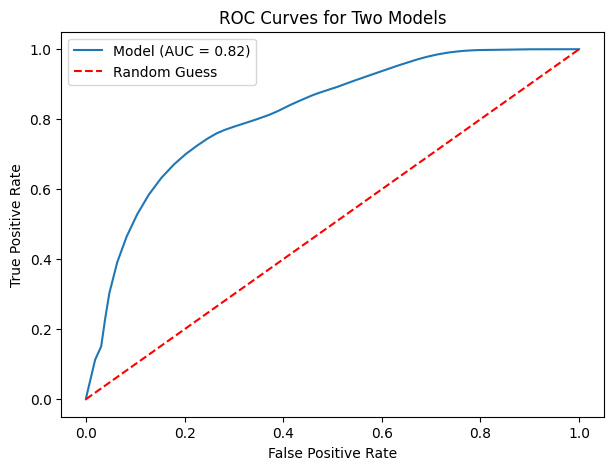

In [22]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [23]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5316
Recall:    0.6705
F1 Score:  0.3542
OA:        0.4309
AA:        0.6705


In [24]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [25]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/RF {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 732133, 'correct_1': 26512, 'correct_total': 758645, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 361184, 'correct_1': 12128, 'correct_total': 373312, 'total': 1248414}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 458098, 'correct_1': 39255, 'correct_total': 497353, 'total': 956340}, {'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 719341, 'correct_1': 31782, 'correct_total': 751123, 'total': 991016}, {'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 348080, 'correct_1': 58363, 'correct_total': 406443, 'total': 1421970}, {'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 685346, 'correct_1': 53237, 'correct_total': 738583, 'total': 1442808}, {'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 67, 'correct_1': 93415, 'correct_total': 

In [26]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

print(timestamp)
print(f"seet used: {seed}")

Run time: 4086.0282 seconds
20250616_110508
seet used: 55
